In [1]:
from src.reachability_analysis.simulation import get_test_label, run_scenario, get_data, get_initial_conditions
from src.clustering.run import load_config, get_cluster
from src.reachability_analysis.labeling_oracle import LABELS, LabelingOracleSINDData
from src.reachability_analysis.utils import load_data
import matplotlib.pyplot as plt
from PIL import Image
import os


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization m

In [2]:
ROOT = os.getcwd()
ROOT_RESOURCES = os.getcwd() + '/resources'

In [3]:
REVERSED_LABELS = {value: key for key, value in LABELS.items()}

In [4]:
model_file = 'SINDDataset_pretrained_2024-04-27_00-11-45_KIP'

index = 2
index_data = 0
folder = 'experiments'

### Zonotopes

In [5]:
ROOT_RESOURCES = ROOT + '/resources'
config = load_config(folder=folder, model_file=model_file, index=index, index_data=index_data)

In [6]:
REVERSED_LABELS

{0: 'cross_left',
 1: 'cross_right',
 2: 'cross_straight',
 3: 'cross_illegal',
 4: 'crossing_now',
 5: 'not_cross',
 6: 'unknown'}

2024-07-25 23:17:10,714 | INFO : Loading 1 datasets files using 1 parallel processes ...
Labeling data: 100%|██████████| 3/3 [00:00<00:00, 4508.39it/s]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-07-25 23:17:10,911 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, b

Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/checkpoints/model_best.pth. Epoch: 28
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.106718
Trajectory data shape need to be of shape  (1, n, m)
Load data from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters
Load Annoy Model from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters/annoy_index.ann


2024-07-25 23:17:11,707 | INFO : Loading 23 datasets files using 20 parallel processes ...


Load data from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters
Load Annoy Model from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters/original_annoy_index.ann
Name: cross_illegal_8_11_1, {'l_3': 'Label: cross_illegal', 'c_13': 'T-b Cluster: 13', 'co_33': 'Cluster: 33'}
(10412, 50) (10412, 50, 6)
(10412,)
(10412, 50) (10412,)
(10412,)


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
Calculating reachable sets:  50%|█████     | 24/48 [00:01<00:01, 12.29it/s]


KeyboardInterrupt: 

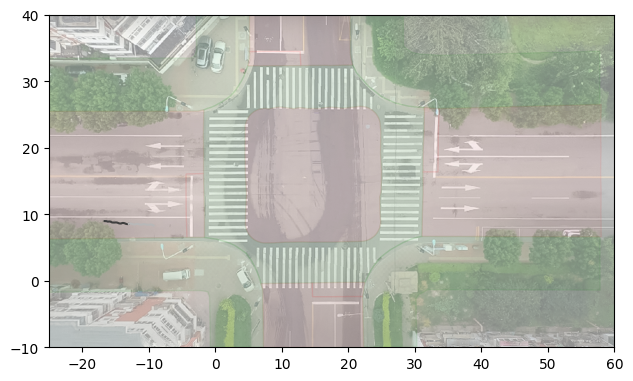

In [7]:
TEST_TRAJECTORIES = [
    'cross_illegal_8_11_1', # nice with the angle filter / without the angle filter, t-b is a bit larger + baseline labeling is the same
    'cross_left_8_6_4', # ISSUE WITH LABELING ORACLE AND filter, ISSUE WITH THE BASELINE TOO MANY DATA / without angle filter labeling too small and issue baseline too big
    'crossing_now_7_28_1', # labeling too too smal / create without the angle filter
]
for name in TEST_TRAJECTORIES:
    config_test = config.copy()
    config_test['data_dir'] = ROOT_RESOURCES + f'/test/{name}'
    config_test['original_data'] = False
    test_labeling_oracle = LabelingOracleSINDData(config_test)

    trajectory, l = get_test_label(test_labeling_oracle)
    c = get_cluster(config_test, test_labeling_oracle)
    
    config_test['original_data'] = True
    test_labeling_oracle = LabelingOracleSINDData(config_test)
    co = get_cluster(config_test, test_labeling_oracle)

    test_cases = {f'l_{l}': f'Label: {REVERSED_LABELS[l]}', f'c_{c}': f'T-b Cluster: {c}',  f'co_{co}': f'Cluster: {co}'}
    
    print(f"Name: {name},", test_cases)
    run_scenario(trajectory=trajectory, config=config, labels=test_cases, show_path=True, baseline=True, show_plot=True, save_plot=config_test['data_dir'])

Combine Final Images for Paper

In [ ]:
TEST_TRAJECTORIES = [
    'cross_illegal_8_11_1',
    'cross_left_8_6_4',
    'crossing_now_7_28_1',
]
def combine_images(image_paths, output_path):
    # Determine the number of images
    num_images = len(image_paths)
    
    # Create a matplotlib figure with multiple subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images * 6, 5))
    
    # Check if there's only one subplot (axes could be an AxesSubplot object, not an array)
    if num_images == 1:
        axes = [axes]
    
    # Loop through the images and their respective axes
    for ax, img_path in zip(axes, image_paths):
        # Open the image file
        with Image.open(img_path) as img:
            # Convert the image file to an array
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust spacing between images if needed
    plt.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

# Example usage
image_paths = [
    ROOT_RESOURCES + f'/test/{TEST_TRAJECTORIES[0]}/0.png',
    ROOT_RESOURCES + f'/test/{TEST_TRAJECTORIES[2]}/0.png',
    ROOT_RESOURCES + f'/test/{TEST_TRAJECTORIES[1]}/0.png',
]
# output_path = ROOT_RESOURCES + '/test/combined_image.jpg'

combine_images(image_paths, output_path)

NameError: name 'output_path' is not defined

### Clsuter picked for Zonotope

In [ ]:
c , l

In [ ]:
_sind_, d, _, mapping = get_data(_load=True, config=config, test_case=(c, 'Cluster'))
_mode = mapping[c]
_mode

In [ ]:
len(d[_mode])

In [ ]:
_sind_.map.plot_dataset(pedestrian_data={i: data for i, data in enumerate(d[_mode])}, color='red', title=f'cluster_{c}', alpha_trajectories=0.3)